In [ ]:
#@title Pip install things - execute one time then reconnect and run all the others
# !sudo apt-get install build-essential swig 
# !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install 
# !pip install auto-sklearn

# !pip install interpret -q
# !pip install interpret-community
# !pip install lime
# # update for PDP to work
# !pip install scikit-learn --upgrade
# # update in order for lime to work
# !pip install xgboost --upgrade
# !pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
# !pip install sklearn-gbmi

# import os

# def restart_runtime():
#   os.kill(os.getpid(), 9)

# restart_runtime()

In [ ]:
import sys
print(sys.version)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [ ]:
#@title Helper Functions (read/write files etc)
import os.path
import io
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin, BaseEstimator
import json

tmpConfig=None
seed=42

def uplodedFileToDf(filesDict,index,save=False):
  fileContent=list(filesDict.values())[index]
  if save==True:
    with open("./tmp_save"+str(index)+".csv", "wb") as fp:
      fp.write(fileContent)
  content = io.StringIO(fileContent.decode('utf-8'))
  return pd.read_csv(content)

def readUploadedFilesToDfs(uploader,save=False):
  result=()
  for x in range(len(uploader)):
    result= result+(uplodedFileToDf(uploader,x,save),)
  return result

def readUploadedFilesToDfsAndSave(uploader):
  return readUploadedFilesToDfs(uploader,True)

def checkForTempFiles():
  X_train=None
  X_test=None
  if os.path.isfile("./tmp_save0.csv"):
      X_train=pd.read_csv("./tmp_save0.csv")
      if os.path.isfile("./tmp_save1.csv"):
        X_test=pd.read_csv("./tmp_save1.csv")
  return X_train,X_test

def getTmpConfigProperty(property):
  global tmpConfig
  if tmpConfig is None and os.path.isfile("./config.json"):
    with open('./config.json', 'r') as f:
      tmpConfig = json.load(f)
  if tmpConfig is None:
    return None
  return tmpConfig.get(property, None)

def setTmpConfigProperty(property,value):
  global tmpConfig
  if os.path.isfile("./config.json"):
    with open('./config.json', 'r') as f:
      tmpConfig = json.load(f)
  if(tmpConfig is None):
    tmpConfig={}
  tmpConfig[property]=value
  with open('./config.json', 'w') as f:
    json.dump(tmpConfig, f)

def getValueFromWidget(widget):
  return widget.value

def executeWithWidgetValueCheck(widget,msg,saveWithProperty=None,cb=getValueFromWidget):
  if widget is not None and ((isinstance(widget.value, dict) and len(widget.value)> 0) or (not isinstance(widget.value, dict) and widget.value is not None)):
    if saveWithProperty is not None:
      setTmpConfigProperty(saveWithProperty,widget.value)
    return cb(widget)
  else:
    raise RuntimeError(msg)

def getTrainAndTestSetXandY(X_train,X_test,y_label):
  y_train=X_train[y_label]
  X_train.drop([y_label],axis=1,inplace=True)
  if (X_test is not None and type(X_test) is not list) and y_label not in X_test:
    raise RuntimeError('The test set has no target variable column named: '+y_label+' !')
  if X_test is not None and type(X_test) is not list:
    y_test=X_test[y_label]
    X_test.drop([y_label],axis=1,inplace=True)
    return X_train,X_test,y_train,y_test
  return train_test_split(X_train, y_train, test_size=0.3, random_state=42)

def getCategoricalColsNameList(df):
  cols = list(df.columns.values)
  num_cols = list(df._get_numeric_data().columns.values)
  return list(set(cols) - set(num_cols)),num_cols


In [ ]:
#@title Column transformer helper

from sklearn.pipeline import Pipeline

import warnings

#https://johaupt.github.io/blog/columnTransformer_feature_names.html
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [f for f in column]

        return [f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [ ]:
#@title Please upload training data as csv file (optional test data)
from google.colab import files


X_train, X_test = checkForTempFiles()
if(X_train is None):
  uploaded = files.upload()
  X_train, *X_test = readUploadedFilesToDfsAndSave(uploaded)

Please upload one (training dataset) or two csv files (train & test dataset) using the Button above.
Consecutively execute the next step

In [ ]:
#@title Please choose the target column
#@title Please chose which kind of prediction 
import ipywidgets as widgets

# X_train, X_test = checkForTempFiles()
# if(X_train is None):
#   X_train, *X_test = executeWithWidgetValueCheck(uploader,'Please upload a file',None,readUploadedFilesToDfsAndSave)
X_train_col_names = X_train.columns.tolist()

select_y_col=widgets.Select(
    options=X_train_col_names,
    value=getTmpConfigProperty('y_col_name') or None
)

reg_classification_dd=widgets.Dropdown(
    options=[('Regression', 1), ('Classification', 2)],
    description='ML goal:',
    value=getTmpConfigProperty('reg_or_class') or None
)

display(reg_classification_dd)
display(select_y_col)

Dropdown(description='ML goal:', index=1, options=(('Regression', 1), ('Classification', 2)), value=2)

Select(index=1, options=('PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket'…

Please chose target variable in the widget above and execute the next step

In [ ]:
#@title Train Data head before processing
y_col_name = executeWithWidgetValueCheck(select_y_col,"Please select the target column",'y_col_name')
reg_or_class = executeWithWidgetValueCheck(reg_classification_dd,"Please select the nature of the predictive modeling problem at hand",'reg_or_class')
X_train, X_test, y_train, y_test = getTrainAndTestSetXandY(X_train,X_test,executeWithWidgetValueCheck(select_y_col,"Please Select a target variable",'y_col_name'))
X_train.head()
#print(X_train.dtypes.to_dict())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
445,446,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S
650,651,3,"Mitkoff, Mr. Mito",male,NaN,0,0,349221,7.8958,NaN,S
172,173,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S
450,451,2,"West, Mr. Edwy Arthur",male,36.0,1,2,C.A. 34651,27.7500,NaN,S
314,315,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.2500,NaN,S


In [ ]:
# #@title delete columns with > 65% of missing values
# def display_missing_values_table_chart(df,axis=1):
#     percent_missing = df.isnull().sum() * 100 / len(df)
#     print(percent_missing)
#     #percent_missing.plot.bar()

# def delete_missing_values_columns(df_train,df_test=None,nanThreshold=65):
#     cols_with_nan = [cname for cname in df_train.columns if 100 * df_train[cname].isnull().sum()/ len(df_train[cname]) > nanThreshold]
#     if (len(cols_with_nan)>0):
#       df_train.drop(cols_with_nan,axis='columns', inplace=True)
#       print('Deleted Columns: ',cols_with_nan,'because it/they had more than',nanThreshold,'% of null values')
#     if(df_test is not None):
#       df_test.drop(cols_with_nan,axis='columns', inplace=True)


# #display_missing_values_table_chart(X_train)
# delete_missing_values_columns(X_train,X_test)

Deleted Columns:  ['Cabin'] because it/they had more than 65 % of null values


In [ ]:
# #@title Delete high cardinal categorical cols
# def get_cardinality_percent(df):
#   res = pd.Series(dtype='int')
#   #catCols,_ = getCategoricalColsNameList(df)
#   for colName in df.columns:
#     col_cardinality=len(pd.unique(df[colName]))
#     percentage=100/len(df[colName])*col_cardinality
#     res=pd.concat([res,pd.Series([percentage],index =[colName])])
#   return res
#   #df.apply(pd.Series.nunique)

# def display_high_cardinalitity(df,axis=1):
#     percent_cardinalitity = get_cardinality_percent(df)
#     percent_cardinalitity.plot.bar()

# def delete_high_cardinalitity(df_train,df_test=None,cardinality_threshold=50):
#   percent_cardinalitity = get_cardinality_percent(df_train)
#   highCardinalCols=percent_cardinalitity[lambda x: x>cardinality_threshold]
#   highCardinalColsIndexList=highCardinalCols.index.values.tolist()
#   if(len(highCardinalColsIndexList)):
#     df_train.drop(highCardinalColsIndexList,axis=1,inplace=True)
#     if(df_test is not None):
#       df_test.drop(highCardinalColsIndexList,axis=1,inplace=True)
#     print("The column(s) '",highCardinalColsIndexList,"' is/are droped as it was a high cardinality feature")

# #display_high_cardinalitity(X_train)
# delete_high_cardinalitity(X_train,X_test)

The column(s) ' ['PassengerId', 'Name', 'Ticket'] ' is/are droped as it was a high cardinality feature


In [ ]:
# #@title Impute all cols with missing values
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
# import warnings

# def impute(df_train,df_test=None,):
#   cat_cols,num_cols=getCategoricalColsNameList(df_train)
#   column_trans = ColumnTransformer(
#   [("num",SimpleImputer(strategy='mean'),num_cols),
#   ("cat", SimpleImputer(strategy='constant'), cat_cols)],
#   remainder='passthrough')
#   missingdata_df = df_train.columns[df_train.isnull().any()].tolist()
  
#   #print('Count of Null\'s in the dataframe: ',len(missingdata_df))
#   df_train_imputed = pd.DataFrame(column_trans.fit_transform(df_train))
  
#   #bring columns and dtypes back
#   originalColNames = get_feature_names(column_trans)
#   df_train_imputed.columns = originalColNames
#   df_train_imputed=df_train_imputed.astype(df_train.dtypes.to_dict())

#   df_test_imputed=None
#   if(df_test is not None):
#       df_test_imputed = pd.DataFrame(column_trans.transform(df_test))
#       df_test_imputed.columns = originalColNames
#       df_test_imputed=df_test_imputed.astype(df_test.dtypes.to_dict())
#   if(missingdata_df):
#       print('The following columns have been imputed:',','.join(missingdata_df))
#   return df_train_imputed,df_test_imputed

# with warnings.catch_warnings():
#   warnings.simplefilter('ignore')
#   X_train,X_test=impute(X_train,X_test)
# #X_train.head()

The following columns have been imputed: Age,Embarked


In [ ]:
# #@title One-hot-encode categorical cols
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

# def encodeCategoricalCols(df_train,df_test=None):
#   cat_cols,num_cols=getCategoricalColsNameList(df_train)
#   res_test=df_test
#   res_train=df_train
#   if (cat_cols is not None and isinstance(cat_cols,list) and len(cat_cols)>0):
#     OH_encoder = OneHotEncoder(handle_unknown='error',drop='if_binary',sparse=False)
#     df_train_OH_cols = pd.DataFrame(OH_encoder.fit_transform(df_train[cat_cols]))
#     df_train_OH_cols.columns = OH_encoder.get_feature_names(cat_cols)
#     df_train.drop(cat_cols, axis=1, inplace=True)
#     res_train = pd.concat([df_train, df_train_OH_cols], axis=1)
#     if(df_test is not None):
#         df_test_OH_cols = pd.DataFrame(OH_encoder.transform(df_test[cat_cols]))
#         df_test_OH_cols.columns = OH_encoder.get_feature_names(cat_cols)
#         df_test_OH_cols.index = df_test.index
#         df_test.drop(cat_cols, axis=1, inplace=True)
#         res_test = pd.concat([df_test, df_test_OH_cols], axis=1)
#     print('Encoded the cols:'+', '.join(cat_cols)  )
#   return res_train,res_test

# X_train,X_test=encodeCategoricalCols(X_train,X_test)
# #X_train.head()

Encoded the cols:Sex, Embarked


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


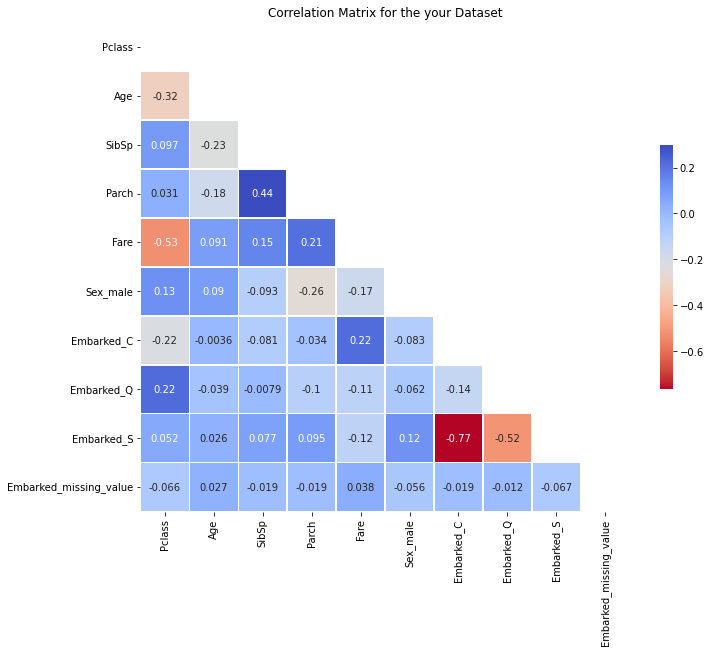

In [ ]:
# #@title Calculaten and plot correlation
# def printCorrMatrix(df):
#   corr = df.corr()
#   # Generate a mask for the upper triangle
#   mask = np.zeros_like(corr, dtype=bool)
#   mask[np.triu_indices_from(mask)] = True
#   # Set up the matplotlib figure
#   f, ax = plt.subplots(figsize=(11, 9))
#   # Draw the heatmap with the mask and correct aspect ratio
#   myplot=sns.heatmap(corr,
#                      mask=mask,
#                      cmap= 'coolwarm_r',
#                      vmax=.3,
#                      annot = True,
#                      square=True,
#                      xticklabels=True,
#                      yticklabels=True,
#                      linewidths=.5,
#                      cbar_kws={"shrink": .5},
#                      ax=ax)
#   plt.title('Correlation Matrix for the your Dataset')
#   #print(np.absolute(corr.values[np.triu_indices_from(corr.values,1)]).mean())

# printCorrMatrix(X_train)

In [ ]:
# #@title Check and counter class imbalance if ratio > 1:2
# from imblearn.combine import SMOTETomek
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler,EditedNearestNeighbours,TomekLinks

# def getCountsPerClass(df):
#   return pd.value_counts(df,sort=True)

# def getRatio(df):
#   count_classes=getCountsPerClass(df)
#   return count_classes[0]/count_classes[1]

# def printClassCount(count_classes):
#     print(count_classes)

# def showBalance(df):
#     count_classes=getCountsPerClass(df)
#     printClassCount(count_classes)
#     print('1 :',count_classes[0]/count_classes[1])
#     #count_classes.plot.bar(rot=0)
    
# def resample(X,y,strategy='auto',algo=None,random_state=1):
#     my_resampler= None
#     if(algo=='SMOTETomek'):
#         my_resampler = SMOTETomek(random_state=random_state)
#     elif(algo=='Tomek'):
#         my_resampler = TomekLinks(random_state=random_state)
#     elif(algo=='ENN'):
#         my_resampler = EditedNearestNeighbours(random_state=random_state)
#     elif(algo=='SMOTE'):
#         my_resampler = SMOTE(random_state=random_state,sampling_strategy = strategy)
#     else:
#         my_resampler = RandomUnderSampler(random_state=random_state,sampling_strategy = strategy,)
    
#     X_resampled, y_resampled = my_resampler.fit_resample(X, y)
#     X_resampled = pd.DataFrame(X_resampled)
#     X_resampled.columns = X.columns
#     y_resampled = pd.Series(y_resampled)
#     printClassCount(y_resampled,'resampled by '+ (algo or 'RUS')+'\n')
#     return X_resampled,y_resampled

# if reg_or_class==2:
#   showBalance(y_train)
#   if getRatio(y_train)>=2:
#     X_train,y_train = resample(X_train,y_train,strategy=1)

0    392
1    231
Name: Survived, dtype: int64
1 : 1.696969696969697


In [ ]:
#@title Please choose XAI mode and scope

model_or_posthoc_dd=widgets.Dropdown(
    options=[('Interpretable Model', 1), ('Post-hoc/model agnostic methods', 2)],
    description='Which class of XAI methods do you want to use:',
    value=getTmpConfigProperty('model_or_posthoc') or None
)
glob_or_local_dd=widgets.Dropdown(
    options=[('Global', 1), ('Local', 2)],
    description='Please choose the explainability mode:',
    value=getTmpConfigProperty('glob_or_local') or None
)
display(model_or_posthoc_dd)
display(glob_or_local_dd)

Dropdown(description='Which class of XAI methods do you want to use:', options=(('Interpretable Model', 1), ('…

Dropdown(description='Please choose the explainability mode:', options=(('Global', 1), ('Local', 2)), value=No…

In [ ]:
#@title
model_or_posthoc = executeWithWidgetValueCheck(model_or_posthoc_dd,"Please select a class of XAI methods",'model_or_posthoc')
glob_or_local = executeWithWidgetValueCheck(glob_or_local_dd,'Please select explainability mode before continuing','glob_or_local')

In [ ]:
#@title Methods for Model agnostic route
if(model_or_posthoc==2):
  
  # from autosklearn.experimental.askl2 import AutoSklearn2Classifier
  # from autosklearn.regression import AutoSklearnRegressor
  from sklearn.metrics import accuracy_score, r2_score
  # from xgboost import XGBRegressor, XGBClassifier
  # import shap
  # from interpret_community.tabular_explainer import TabularExplainer

  # import lime
  # import lime.lime_tabular
  # from sklearn.inspection import PartialDependenceDisplay
  # from alepython import ale_plot
  # from sklearn.inspection import permutation_importance
  # from interpret.ext.blackbox import MimicExplainer
  # from interpret.ext.glassbox import LGBMExplainableModel
  from sklearn.metrics import r2_score

  # def trainBlackBoxModel(reg_or_class,df_train, df_y_train,df_test,df_y_test,model=None):
  #   if(reg_or_class==2):
  #     return trainBlackBoxClassModel(df_train, df_y_train,df_test,df_y_test,model)
  #   else:
  #     return trainBlackBoxRegModel(df_train, df_y_train,df_test,df_y_test,model)


  # def trainBlackBoxClassModel(df_train, df_y_train,df_test,df_y_test,model=None):
  #   global seed
  #   my_model= None
  #   if(model=='autoML'):
  #     my_model = AutoSklearn2Classifier(random_state=seed)
  #   # elif(model=='Tomek'):
  #   #   my_model = SMOTETomek(random_state=random_state)
  #   else:
  #     my_model = XGBClassifier(random_state=seed)
    
  #   # my_model.fit(df_train.values, df_y_train)
  #   my_model.fit(df_train, df_y_train)
  #   test_predictions = my_model.predict(df_test)
  #   print("Accuracy score", accuracy_score(df_y_test, test_predictions))
  #   return my_model

  # def trainBlackBoxRegModel(df_train, df_y_train,df_test,df_y_test,model=None):
  #   global seed
  #   my_model= None
  #   if(model=='autoML'):
  #     my_model = AutoSklearnRegressor(
  #     time_left_for_this_task=120,
  #     per_run_time_limit=30,
  #     tmp_folder='/tmp/autosklearn_regression_example_tmp',
  #   )
  #   # elif(model=='Tomek'):
  #   #   my_model = SMOTETomek(random_state=random_state)
  #   else:
  #     my_model = XGBRegressor(n_estimators=1000,verbose=False)
    
  #   my_model.fit(df_train, df_y_train)
  #   # my_model.fit(df_train.values, df_y_train)
  #   test_predictions = my_model.predict(df_test)
  #   print("Test R2 score:", r2_score(df_y_test, test_predictions))
  #   return my_model

  # def globalMethod(model,df_train,df_test,df_train_y,df_test_y):
  #   applyGlobalSurrogate(model, df_train,df_test)
  #   #applyPFI(model,df_train,df_train_y)
  #   #applyALE(model,df_train,)
  #   #applyICE(model,df_train,df_test)
  #   #applySHAP(model,df_train,df_test)

  # def localMethod(model,df_train,df_test,df_train_y):
  #   applyLime(model,df_train,df_test,df_train_y)
   

  # #----------local methods-------------
  # def applyLime(model,df_train,df_test,df_train_y,index=42):
  #   explainer = lime.lime_tabular.LimeTabularExplainer(
  #       np.array(df_train),
  #       mode = (reg_or_class==1 and 'regression') or 'classification',
  #       feature_names=np.array(df_train.columns),
  #       class_names=df_train_y.unique(),
  #       discretize_continuous=True
  #   )
  #   i = np.random.randint(0, df_test.shape[0])
  #   exp = explainer.explain_instance(
  #       np.array(df_train)[i],
  #        (reg_or_class==1 and model.predict) or model.predict_proba,
  #        num_features=5
  #   )
  #   exp.show_in_notebook(show_all=True)

  #----------global methods-------------
  # def applySHAP(model,df_train):
  #   explainer = shap.Explainer(model)
  #   shap_values = explainer(df_train)
  #   shap.plots.bar(shap_values)

  # def applyICE(model,df_train,number_of_feature_to_display=0):
  #   pdp = PartialDependenceDisplay.from_estimator(model,       
  #                                  df_train,
  #                                  features=[number_of_feature_to_display],
  #                                  feature_names=df_train.columns.values.tolist(),
  #                                  grid_resolution=100,
  #                                  ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
  #                                  pd_line_kw={"color": "tab:orange", "linestyle": "--"},
  #                                  kind='both')
    
  # def applyPFI(model,df_train,df_train_y):
  #   result = permutation_importance(model,
  #                                   df_train,
  #                                   df_train_y,
  #                                   n_repeats=10,
  #                                   random_state=42,
  #                                   n_jobs=-1)
  #   sorted_idx = result.importances_mean.argsort()
  #   fig, ax = plt.subplots()
  #   fpi=ax.boxplot(result.importances[sorted_idx].T,vert=False, labels=X_test.columns[sorted_idx])
  #   ax.set_title("Permutation Importances Titanic dataset (training set)")
  #   fig.tight_layout()
  #   plt.show()

# def applyALE(model, df_train, number_of_feature_to_display=0):
#     nameOfFeature=df_train.columns.values.tolist()[number_of_feature_to_display]
#     ale = ale_plot(model, df_train, nameOfFeature, monte_carlo=True)

# def applyGlobalSurrogate(model, df_train,df_test, number_of_feature_to_display=0):
#   surrogate = LGBMExplainableModel
#   explainer = MimicExplainer(model,
#                            df_train,
#                            surrogate,
#                            augment_data=False,
#                            features=df_train.columns)

#   global_explanation = explainer.explain_global(df_test)
#   fig=global_explanation.visualize()
#   fig.show()


In [ ]:
# if(model_or_posthoc==2):
#   model=trainBlackBoxModel(reg_or_class,X_train, y_train,X_test,y_test)
#   if(glob_or_local==2):
#     localMethod(model,X_train,X_test,y_train)
#   else:
#     globalMethod(model,X_train,X_test,y_train,y_test)
#   #from pprint import pprint
#   #pprint(automl.show_models(), indent=4)
#   #print(automl.leaderboard())

  

In [ ]:
#async example
# from ipywidgets import Button
# import asyncio

# def wait_for_change(widget):
#     future = asyncio.Future()
#     def getvalue(change):
#         future.set_result(change.description)
#         widget.on_click(getvalue, remove=True) 
#         # we need to free up the binding to getvalue to avoid an InvalidState error
#         # buttons don't support unobserve
#         # so use `remove=True` 
#     widget.on_click(getvalue)
#     return future

# button = Button(description="wow")

# list_to_tag = ["one", "two", "three", "four"]

# async def f():
#     for i in list_to_tag:
#         print("going to tag {}".format(i))
#         x = await wait_for_change(button)
#         print("tagged {} with {}".format(i, x))
#         print()

# asyncio.create_task(f())
# button

In [ ]:
#@title Methods for interpretable Model route
from interpret import show
# from abc import ABC, abstractmethod
# from interpret.glassbox import ExplainableBoostingRegressor, LogisticRegression, LinearRegression, RegressionTree
# from interpret.glassbox import ExplainableBoostingClassifier, ClassificationTree, DecisionListClassifier

# class XAIMethod(ABC):

#   @classmethod
#   @property
#   @abstractmethod
#   def CONSTANT(cls):
#       raise NotImplementedError
  
#   @classmethod
#   def __init__(self, df_train, df_y_train):
#         self.train(df_train, df_y_train)
#         self.showExplanation(1)
        
#   @classmethod
#   def getMethodStrName(self):
#     return type(self.CONSTANT).__name__

#   @classmethod
#   def train(self,df_train, df_y_train):
#     self.CONSTANT.fit(df_train, df_y_train)

#   @classmethod
#   def showExplanation(self,glob_or_local):
#     if(glob_or_local==1):
#       globalExp = self.CONSTANT.explain_global(name=self.getMethodStrName())
#       show(globalExp)
#     else:
#       localExp = self.CONSTANT.explain_local(X_test[:5], y_test[:5], name=self.getMethodStrName())
#       show(localExp)


# class MethodClassTree(XAIMethod):
#   CONSTANT = ClassificationTree()

# class MethodClassDecisionList(XAIMethod):
#   CONSTANT = DecisionListClassifier()

# class MethodClassEBM(XAIMethod):
#   CONSTANT = ExplainableBoostingClassifier(n_jobs=-1)

# # class  MethodClassGAM(XAIMethod):
# #   CONSTANT = (n_jobs=-1)

# class MethodRegLog(XAIMethod):
#   CONSTANT = LogisticRegression()

# class MethodRegLinear(XAIMethod):
#   CONSTANT = LinearRegression()

# class MethodRegTree(XAIMethod):
#   CONSTANT = RegressionTree()

# class MethodRegEBM(XAIMethod):
#   CONSTANT = ExplainableBoostingRegressor(n_jobs=-1)

# # # https://medium.com/just-another-data-scientist/building-interpretable-models-with-generalized-additive-models-in-python-c4404eaf5515
# # class MethodRegGAM(XAIMethod):
# #   CONSTANT = (n_jobs=-1)


# def trainGlassBoxRegMLModel(df_train, df_y_train,model=None):
#   if(model=='logistic'):
#     MethodRegLog(df_train, df_y_train)
#   elif(model=='linear'):
#     MethodRegLinear(df_train, df_y_train)
#   elif(model=='decisionTree'):
#     MethodRegTree(df_train, df_y_train)
#   elif(model=='GAM'):
#     MethodRegGAM(df_train, df_y_train)
#   else:
#     MethodRegEBM(df_train, df_y_train)

# def trainGlassBoxClassMLModel(df_train, df_y_train,model=None):
#   if(model=='decisionTree'):
#     MethodClassTree(df_train, df_y_train)
#   elif(model=='rules'):
#     MethodClassDecisionList(df_train, df_y_train)
#   elif(model=='GAM'):
#     MethodClassGAM(df_train, df_y_train)
#   else:
#     MethodClassEBM(df_train, df_y_train)


In [ ]:
classMethods=['rules','decisionTree','ebm','GAM'];
regMethods=['logistic','linear','decisionTree','ebm','GAM'];

modelStrDD=widgets.Dropdown(
    options=(classMethods,regMethods)[reg_or_class==1],
    description='Please choose a model',
    value=getTmpConfigProperty('modelStr') or None
)
display(modelStrDD)

Dropdown(description='Please choose a model', options=('rules', 'decisionTree', 'ebm', 'GAM'), value=None)

In [ ]:
# if(model_or_posthoc==1):
#   modelStr = executeWithWidgetValueCheck(modelStrDD,"Please select a glassbox model",'modelStr')
#   if(reg_or_class==2):
#     trainGlassBoxClassMLModel(X_train, y_train, modelStr)
#   else:
#     trainGlassBoxRegMLModel(X_train, y_train, modelStr)

/usr/local/lib/python3.7/dist-packages/interpret/provider/visualize.py:44: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  detected_envs


In [ ]:
#from interpret.data import Marginal
#from interpret.perf import RegressionPerf
#from sklearn.ensemble import RandomForestRegressor
# lr = LinearRegression(random_state=seed)
# lr.fit(X_train, y_train)

# rt = RegressionTree(random_state=seed)
# rt.fit(X_train, y_train)

# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
# rf.fit(X_train, y_train)

# ebm_perf = RegressionPerf(interpretableModel.predict).explain_perf(X_test, y_test, name='EBM')
# lr_perf = RegressionPerf(lr.predict).explain_perf(X_test, y_test, name='Linear Regression')
# rt_perf = RegressionPerf(rt.predict).explain_perf(X_test, y_test, name='Regression Tree')
# rf_perf = RegressionPerf(rf.predict).explain_perf(X_test, y_test, name='Blackbox')
# lr_global = lr.explain_global(name='Linear Regression')
# rt_global = rt.explain_global(name='Regression Tree')

# show(lr_perf)
# show(rt_perf)
# show(ebm_perf)
# show(rf_perf)
#show([lr_perf,rt_perf,ebm_perf,rf_perf])